https://towardsdatascience.com/a-practical-example-in-transfer-learning-with-pytorch-846bb835f2db

In [1]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

Import del Dataset

In [2]:
# https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset

import os
from matplotlib import pyplot as plt
import random

os.environ['KAGGLE_USERNAME'] = "alebelo" # username from the json file
os.environ['KAGGLE_KEY'] = "608d2c18368663d519f0536d566b0dcb" # key from the json file

!kaggle datasets download -d nunenuh/pytorch-challange-flower-dataset # api copied from kaggle
!unzip -o ./pytorch-challange-flower-dataset.zip
os.remove('pytorch-challange-flower-dataset.zip')

Output streaming troncato alle ultime 5000 righe.
  inflating: dataset/train/48/image_04685.jpg  
  inflating: dataset/train/48/image_04686.jpg  
  inflating: dataset/train/48/image_04689.jpg  
  inflating: dataset/train/48/image_04692.jpg  
  inflating: dataset/train/48/image_04694.jpg  
  inflating: dataset/train/48/image_04695.jpg  
  inflating: dataset/train/49/image_06198.jpg  
  inflating: dataset/train/49/image_06199.jpg  
  inflating: dataset/train/49/image_06200.jpg  
  inflating: dataset/train/49/image_06201.jpg  
  inflating: dataset/train/49/image_06203.jpg  
  inflating: dataset/train/49/image_06204.jpg  
  inflating: dataset/train/49/image_06205.jpg  
  inflating: dataset/train/49/image_06206.jpg  
  inflating: dataset/train/49/image_06207.jpg  
  inflating: dataset/train/49/image_06208.jpg  
  inflating: dataset/train/49/image_06211.jpg  
  inflating: dataset/train/49/image_06212.jpg  
  inflating: dataset/train/49/image_06214.jpg  
  inflating: dataset/train/49/image_06

In [3]:
# Set Train and Test Directory Variables
TRAIN_DATA_DIR = "./dataset/train/"
VALID_DATA_DIR = "./dataset/valid/"

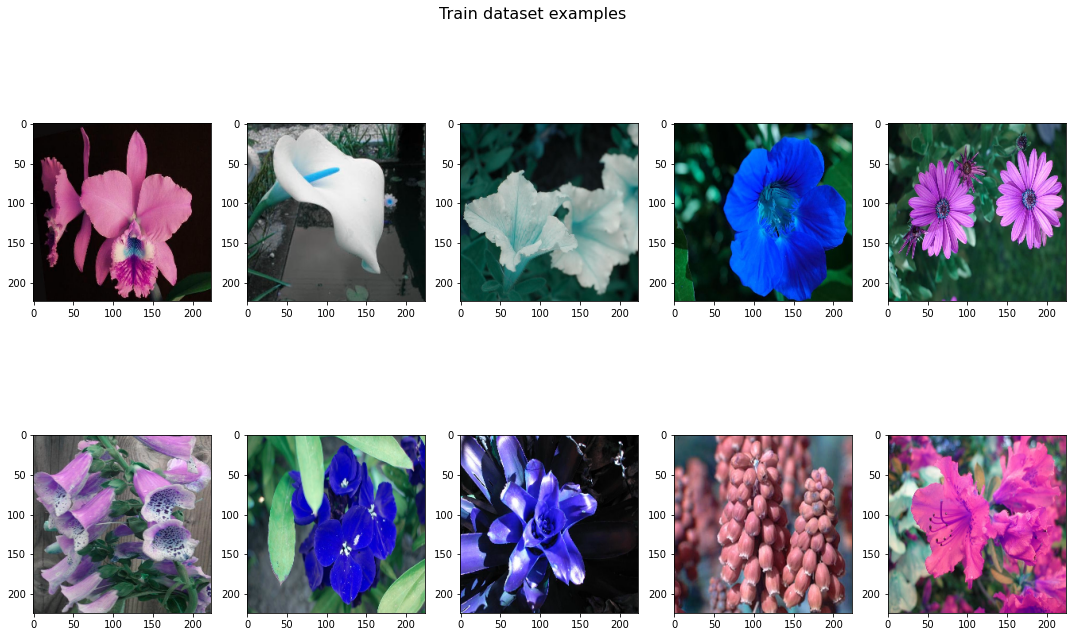

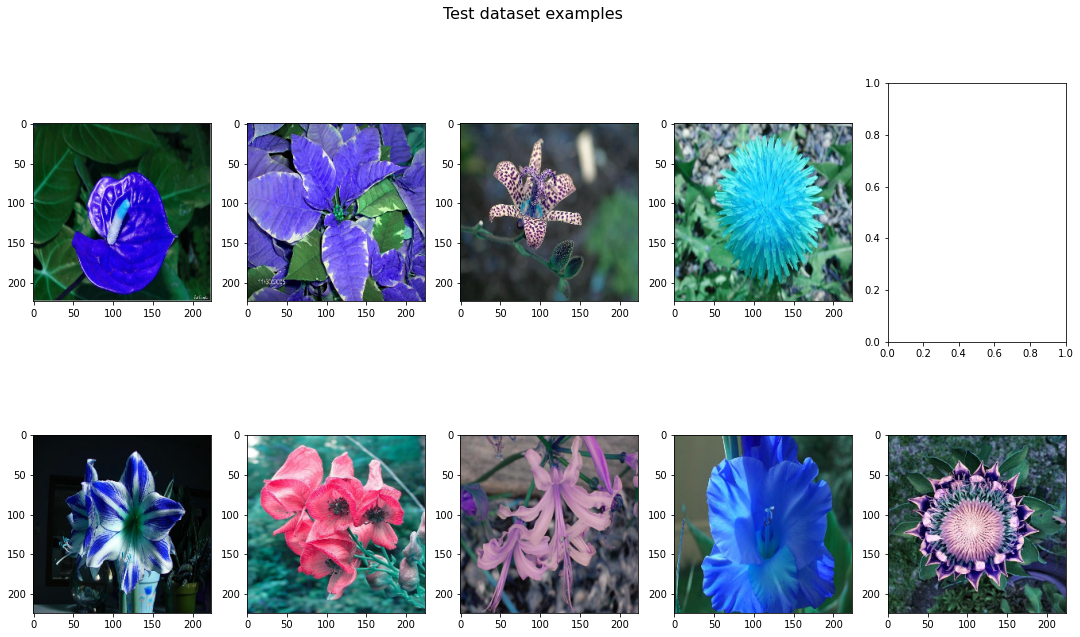

In [4]:
import numpy as np # linear algebra
import cv2
import matplotlib.pyplot as plt

##### VISUALIZZAZIONE DI 10 IMG DI TRAINING E 10 DI TESTING #######à

fig_train, axs_train = plt.subplots(2, 5)
fig_train.set_size_inches(18.5, 10.5)
fig_train.suptitle("Train dataset examples", fontsize=16)
for i in range(2):
  for j in range(5):
    FILE_DIR = str(np.random.randint(1,103))
    for file_name in os.listdir(os.path.join(TRAIN_DATA_DIR, FILE_DIR))[1:3]:
      img_array = cv2.imread(os.path.join(TRAIN_DATA_DIR, FILE_DIR, file_name))
      img_array = cv2.resize(img_array,(224, 224), interpolation = cv2.INTER_CUBIC)
      axs_train[i,j].imshow(img_array)

fig_train, axs_train = plt.subplots(2, 5)
fig_train.set_size_inches(18.5, 10.5)
fig_train.suptitle("Test dataset examples", fontsize=16)
for i in range(2):
  for j in range(5):
    FILE_DIR = str(np.random.randint(1,103))
    for file_name in os.listdir(os.path.join(VALID_DATA_DIR, FILE_DIR))[1:3]:
      img_array = cv2.imread(os.path.join(VALID_DATA_DIR, FILE_DIR, file_name))
      img_array = cv2.resize(img_array,(224, 224), interpolation = cv2.INTER_CUBIC)
      axs_train[i,j].imshow(img_array)


In [5]:
from pickle import FALSE
import shutil
# sposto le immagini nella cartella test in modo da avere 80%-20%
cont = 650
dirImg = TRAIN_DATA_DIR
label_name = [f for f in os.listdir(dirImg) ]
dest = VALID_DATA_DIR

def selectRandom(names, num):
  x = []
  for i in range(1, num):
    el = np.random.choice(a=names,replace=False)
    if el not in x:
      x.append(el)
  return x

for name in label_name:
  tmp = [f for f in os.listdir(os.path.join(dirImg, name)) ]
  image_name = selectRandom(tmp, int(len(tmp)/2))
  for img in image_name:
    if cont >= 1:
      test_name = [f for f in os.listdir(dest) ]
      for test_label in test_name:
       if name==test_label:
        shutil.move(os.path.join(dirImg, name, img), os.path.join(dest, test_label))
      cont = cont - 1

In [6]:
# Load and transform data using ImageFolder
# Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(TRAIN_DATA_DIR, transform=data_transform)
test_data = datasets.ImageFolder(VALID_DATA_DIR, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

# I used os.listdir() to maintain the ordering 
classes = os.listdir(VALID_DATA_DIR)

Num training images:  5902
Num test images:  1468


In [7]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=8,
    shuffle=True,  # set to True to have the data reshuffled at every epoch
    num_workers=4  # how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process
)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=8,
    shuffle=True,
    num_workers=4
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
from torchvision.models import ViT_L_16_Weights

# https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.ViT_B_16_Weights
# i pesi della rete sono scelti in modo da essere simili a quelli del modello ResNet
model = models.vit_l_16(weights = ViT_L_16_Weights.IMAGENET1K_V1)

for param in model.parameters():
        param.requires_grad = False


model.heads=torch.nn.Sequential(torch.nn.Linear(model.heads.head.in_features, 256),
torch.nn.Dropout(0.3), 
torch.nn.ReLU(inplace=False),
torch.nn.Linear(256, 102))



Downloading: "https://download.pytorch.org/models/vit_l_16-852ce7e3.pth" to /root/.cache/torch/hub/checkpoints/vit_l_16-852ce7e3.pth


  0%|          | 0.00/1.13G [00:00<?, ?B/s]

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

NUM_EPOCHS = 25
device = torch.device('cuda')
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_acc = []
train_loss = []
test_acc = []
test_loss = []
y_pred = []
y_true = []
cont = 0

print(len(train_data))

for epoch in range(NUM_EPOCHS):
    
    train_error_count = 0.0
    loss_cum = 0
    correct = 0
    total = 0
    for images, labels in iter(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(outputs, labels)   

        loss.backward()
        optimizer.step()

        loss_cum += loss.item()   # sommo il valore di loss di ogni immagine
        cont = cont + 1 

        train_error_count += float(torch.sum(torch.abs(labels - outputs.argmax(1))))

        _, predicted = outputs.max(1)
        total += int(labels.shape[0])
        correct += predicted.eq(labels).sum().item()
        
    train_acc.append(correct/total)

    train_loss.append((loss_cum/len(train_data))) # lo aggiungo alla lista delle loss di ogni epoca
    loss_cum = 0
    cont = 0
 
    test_error_count = 0.0
    correct = 0
    total = 0
    for images, labels in iter(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)        
        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(outputs, labels)   

        loss.backward()
        optimizer.step()

        # loss.item() contains the loss of the entire mini-batch,  It’s because the loss
        # given loss functions is divided by the number of elements i.e. the reduction parameter is mean by default(divided by the batch size)
        loss_cum += loss.item()   # sommo il valore di loss di ogni immagine
        cont = cont + 1  

        test_error_count += float(torch.sum(torch.abs(labels - outputs.argmax(1))))

        output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

        _, predicted = outputs.max(1)
        total += int(labels.shape[0])
        correct += predicted.eq(torch.from_numpy(labels).to(device)).sum().item()

    test_acc.append(correct/total)

    test_loss.append((loss_cum/len(test_data))) # lo aggiungo alla lista delle loss di ogni epoca
    cont = 0
    
    print("Epoch {}/{}, Train Loss: {:.3f}, Test Loss: {:.3f}, Train Accuracy: {:.3f}, Test Accuracy: {:.3f}".format(epoch+1,NUM_EPOCHS,train_loss[epoch],test_loss[epoch],train_acc[epoch],test_acc[epoch],))

5902
Epoch 1/25, Train Loss: 0.475, Test Loss: 0.337, Train Accuracy: 0.197, Test Accuracy: 0.396
Epoch 2/25, Train Loss: 0.252, Test Loss: 0.180, Train Accuracy: 0.544, Test Accuracy: 0.670
Epoch 3/25, Train Loss: 0.155, Test Loss: 0.115, Train Accuracy: 0.711, Test Accuracy: 0.786
Epoch 4/25, Train Loss: 0.114, Test Loss: 0.093, Train Accuracy: 0.790, Test Accuracy: 0.832
Epoch 5/25, Train Loss: 0.091, Test Loss: 0.076, Train Accuracy: 0.830, Test Accuracy: 0.860
Epoch 6/25, Train Loss: 0.075, Test Loss: 0.069, Train Accuracy: 0.857, Test Accuracy: 0.875
Epoch 7/25, Train Loss: 0.065, Test Loss: 0.058, Train Accuracy: 0.883, Test Accuracy: 0.890
Epoch 8/25, Train Loss: 0.057, Test Loss: 0.053, Train Accuracy: 0.893, Test Accuracy: 0.899
Epoch 9/25, Train Loss: 0.053, Test Loss: 0.048, Train Accuracy: 0.902, Test Accuracy: 0.903
Epoch 10/25, Train Loss: 0.048, Test Loss: 0.045, Train Accuracy: 0.908, Test Accuracy: 0.919
Epoch 11/25, Train Loss: 0.044, Test Loss: 0.043, Train Accuracy

In [11]:
print("TRAIN LOSS: ")
for i in range(NUM_EPOCHS):
  print(str(round(train_loss[i],3)) + ",", end=" ")
print("\n")

print("TRAIN ACCURACY: ")
for i in range(NUM_EPOCHS):
  print(str(round(train_acc[i],3)) + ",", end=" ")
print("\n")

print("TEST LOSS: ")
for i in range(NUM_EPOCHS):
  print(str(round(test_loss[i],3)) + ",", end=" ")
print("\n")

print("TEST ACCURACY: ")
for i in range(NUM_EPOCHS):
  print(str(round(test_acc[i],3)) + ",", end=" ")

TRAIN LOSS: 
0.475, 0.252, 0.155, 0.114, 0.091, 0.075, 0.065, 0.057, 0.053, 0.048, 0.044, 0.042, 0.04, 0.038, 0.037, 0.034, 0.033, 0.029, 0.031, 0.027, 0.026, 0.026, 0.025, 0.024, 0.022, 

TRAIN ACCURACY: 
0.197, 0.544, 0.711, 0.79, 0.83, 0.857, 0.883, 0.893, 0.902, 0.908, 0.914, 0.922, 0.925, 0.925, 0.929, 0.937, 0.936, 0.942, 0.94, 0.947, 0.951, 0.95, 0.95, 0.954, 0.959, 

TEST LOSS: 
0.337, 0.18, 0.115, 0.093, 0.076, 0.069, 0.058, 0.053, 0.048, 0.045, 0.043, 0.036, 0.036, 0.031, 0.034, 0.029, 0.026, 0.031, 0.025, 0.028, 0.025, 0.023, 0.023, 0.021, 0.02, 

TEST ACCURACY: 
0.396, 0.67, 0.786, 0.832, 0.86, 0.875, 0.89, 0.899, 0.903, 0.919, 0.919, 0.931, 0.93, 0.941, 0.933, 0.946, 0.951, 0.942, 0.957, 0.941, 0.951, 0.948, 0.957, 0.958, 0.96, 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(0, NUM_EPOCHS), train_acc, label="Train accuracy")
plt.plot(np.arange(0, NUM_EPOCHS), train_loss, label="Train loss")
plt.plot(np.arange(0, NUM_EPOCHS), test_acc, label="Test accuracy")
plt.plot(np.arange(0, NUM_EPOCHS), test_loss, label="Test loss")
plt.title("Accuracy [Flower Dataset]")
plt.xlabel("Epoche")
plt.ylabel("Accuracy/Loss")
plt.legend(loc="center")

In [ ]:
from numpy.core.fromnumeric import size
# https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
# Build confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cf_matrix = confusion_matrix(y_true, y_pred)

cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Blight', 'Common_Rust','Gray_Leaf_Spot','Healthy'])
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)